# Neural Style Transfer

**Resources:**
* [Original paper - A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)
* [Demystifying Neural Style Transfer](https://arxiv.org/abs/1701.01036)
* [Official PyTorch Tutorial](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)
* [Blog by Amar](https://towardsdatascience.com/implementing-neural-style-transfer-using-pytorch-fd8d43fb7bfa)

## Paper overview
### Model

Here is how each image is "ran-forward" with vgg19 and what outputs are saved/used to optimize the **output image (Generated image)**

![model](https://user-images.githubusercontent.com/16206648/139554170-1c63cd04-c83f-4ea8-bb12-da05b87d5c9a.jpg)


### Loss

#### Total Loss

$$
\mathcal{L}_{total}(\vec{p}, \vec{a}, \vec{x}) = \alpha\mathcal{L}_{content}(\vec{p}, \vec{x}) + \beta\mathcal{L}_{style}(\vec{a}, \vec{x}) \tag{1}
$$
$ \vec{p} $ - content image  
$ \vec{a} $ - style image   
$ \vec{x} $ - generated image   
$ \alpha $ - content coefficient   
$ \beta $ - style cooefficient 

> Generated image $\vec{x}$ can be either initialized as content image or white noise (random values).

#### Content Loss

$$
\mathcal{L}_{content}(\vec{p}, \vec{x}) = \dfrac{1}{2} \sum_{i,j}(F_{i,j}^{l} - P_{i,j}^{l})^2 \tag{2}
$$

Content loss is a squared error between: 
  
$ F_{i,j}^{l} $ - Output of conv layer **$l$** for input (generated) image  
$ P_{i,j}^{l} $ - Output of conv layer **$l$** for content image  

> $ i, j $ represent **i-th** position of the filter at position **j** which implementation-wise doesn't change anything as we take whole outputs of conv layers

There's a small difference in notation when it comes to implementation. In paper, $F^{l}$ is defined as $F^{l} \in \mathbb{R}^{N_l x M_l}$, which means it's a matrix with shape ($N_l$ - number of feature maps, $M_l$ - $width * height$ of feature maps). In contrast, here we have $F^{l} \in \mathbb{R}^{N_l x H_l x W_l}$ which is just a reshaped version of the matrix in the paper.

#### Style Loss

Instead of taking raw conv layer outputs as in content loss, style loss firstly computes Gram matrix. They mentioned that Gram matrix computes feature correlations between feature maps? (will have to look more into what that exactly means).
$$
G_{i,j}^l = \sum_{k}(F_{i,k}^lF_{j,k}^l) \tag{3}
$$
where:

$F_{i,k}^l$ is output of conv layer **$l$**, defined as $F^{l} \in \mathbb{R}^{N_l x M_l}$, where $(N_l = channels, M_l = height * width)$  
$F_{j,k}^l$ is transposed version of previously mentioned matrix

This essentially means $G$ is computed as $F * F^T$ and $G \in \mathbb{R}^{NxN}$

> Because $G$ is of shape $NxN$, it means that the dimensions of Gram matrix vary between conv layers with different number of feature maps. In official PyTorch tutorial this is resolved by normalazing each gram matrix by dividing it with its number of elements. I haven't seen this in paper but I'll test both **with** and **without** normalization.

With *Gram matrix* defined, they computed the **loss per layer** as mean-squared error:
$$
E_l = \dfrac{1}{4N_l^2M_l^2}\sum_{i,j}(G_{i,j}^l-A_{i,j}^l)^2\tag{4}
$$
> I am really not sure how this formula is mean...

## Experiments

Here I examined several experiments:
1. Gram matrix values (Normalized vs Not-normalized)
2. Number of iterations (Differences in quality)
3. Impact of style losses in different layers
4. Adam vs LBFG-S optimizer

### Experiment pre-setup

In [2]:
import torch
from PIL import Image

from src.model import VGG19
from src.style_transfer import style_transfer
from src.utils import plot_images

# Setup model for experiments
content_layer_ids = [21]               # conv4_2
style_layer_ids = [0, 5, 10, 19, 28]   # conv1_1, conv2_1, conv3_1, conv4_1, conv5_1

# Init model
model = VGG19(
    content_layer_ids=content_layer_ids,
    style_layer_ids=style_layer_ids,
)

# Load the images
content_image_path = 'images/Tuebingen_Neckarfront.jpg'
style_image_paths = [
    'images/The_Scream.jpg',
    'images/Van_Gogh_Starry_Night.jpg',
    'images/Shipwreck_of_the_Minotaur_William_Turner.jpg',
    'images/Pablo_Picasso_Figure_dans_un_Fauteuil.jpg',
    'images/Vassily_Kandinsky_Composition_7.jpg',
]

content_image = Image.open(content_image_path)
style_images = [Image.open(style_image_path) for style_image_path in style_image_paths]

### Gram matrix values (Normalized vs Not-normalized)
 
Images without normalization tend to be very blurry.

Running style transfer: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.24s/it]


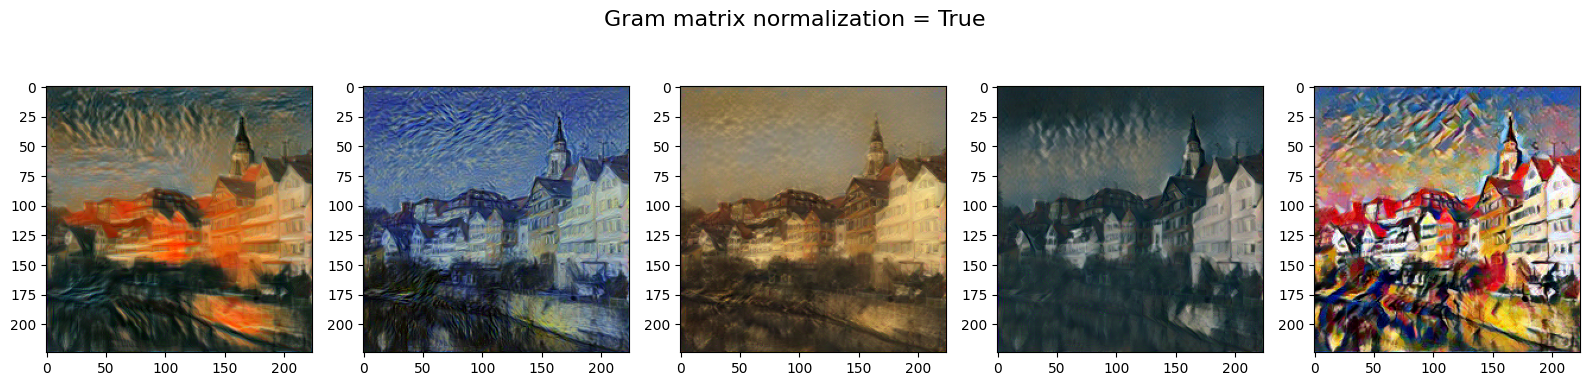

In [2]:
# Run style transfer and plot the results
images = []
for style_image in style_images:
    loss, output_img = style_transfer(model=model, content_image=content_image, style_image=style_image, 
                                      alpha=1., beta=1000., iterations=10, init_output='content', normalize_gram_matrix=True)
    images.append(output_img)
    
fig = plot_images(images, "Gram matrix normalization = True")

Running style transfer: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.28s/it]


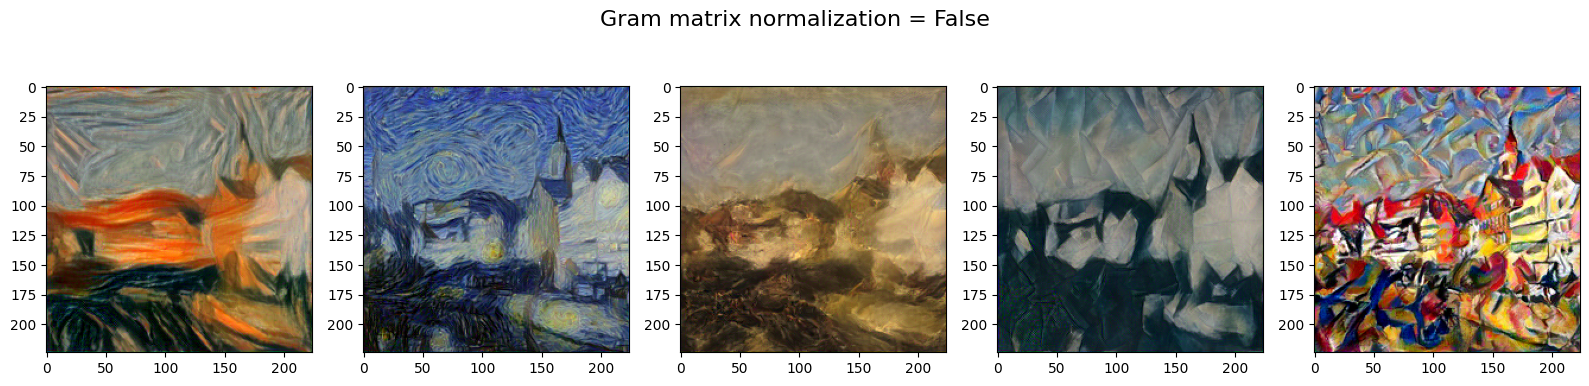

In [4]:
# Run style transfer and plot the results
images = []
for style_image in style_images:
    loss, output_img = style_transfer(model=model, content_image=content_image, style_image=style_image, 
                                      alpha=1., beta=1000., iterations=10, init_output='content', normalize_gram_matrix=False)
    images.append(output_img)
    
fig = plot_images(images, "Gram matrix normalization = False")

### Number of iterations

Number of iteration isn't exactly corret. LBFGS optimizer does 20 updates per iterations. So the number of steps is
* 5 iterations = 100 steps
* 10 terations = 200 steps
* 20 iterations = 400 steps

There isn't a *huge* difference in generated images as the **loss** seems to drop quite fast. More on losses in later experiments.

Running style transfer: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.18s/it]


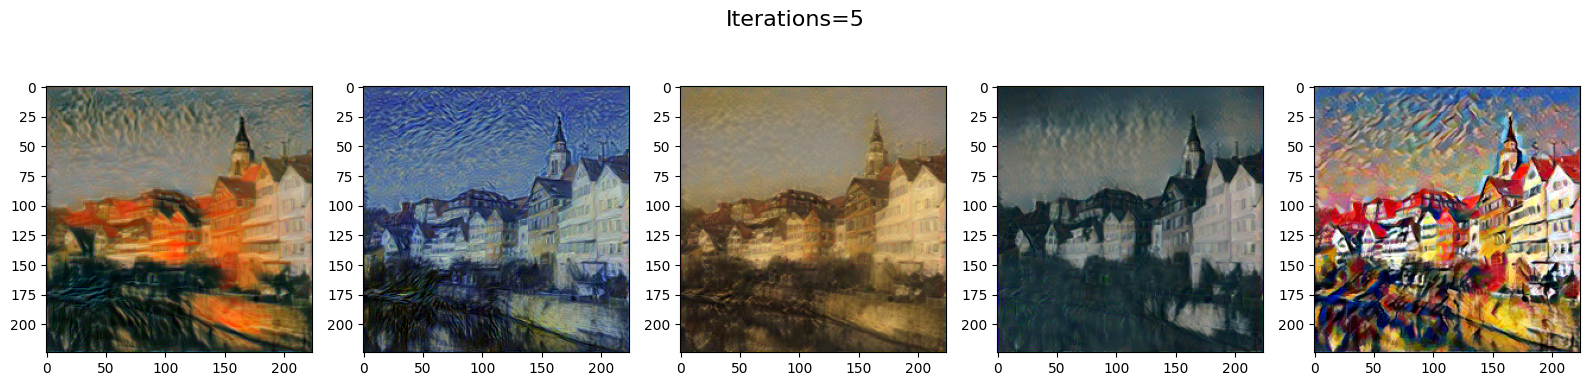

In [8]:
images = []
for style_image in style_images:
    loss, output_img = style_transfer(model=model, content_image=content_image, style_image=style_image, 
                                      alpha=1., beta=1000., iterations=5, init_output='content', normalize_gram_matrix=True)
    images.append(output_img)
    
fig = plot_images(images, "Iterations=5")

Running style transfer: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.31s/it]


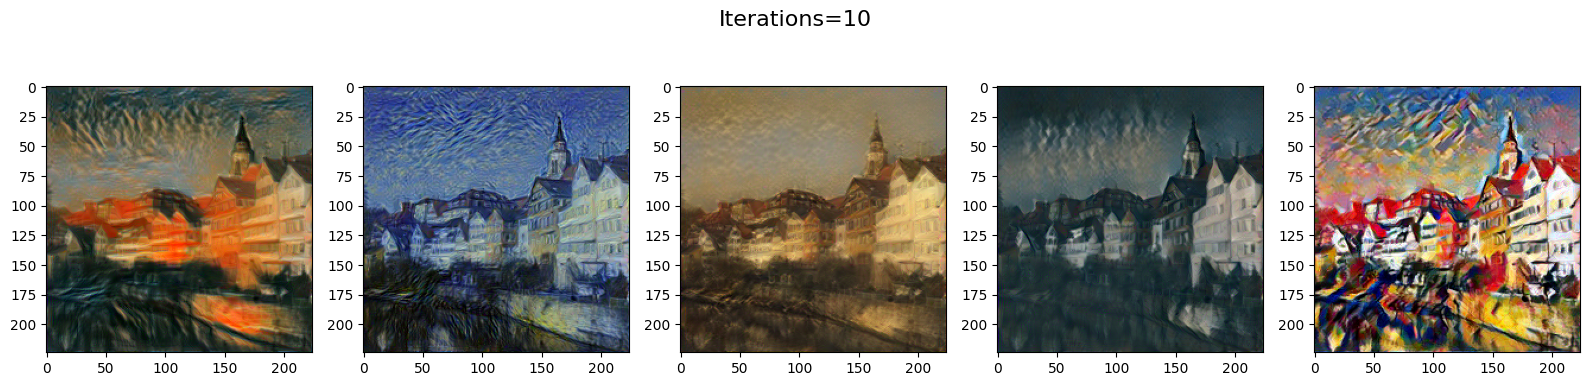

In [9]:
images = []
for style_image in style_images:
    loss, output_img = style_transfer(model=model, content_image=content_image, style_image=style_image, 
                                      alpha=1., beta=1000., iterations=10, init_output='content', normalize_gram_matrix=True)
    images.append(output_img)
    
fig = plot_images(images, "Iterations=10")

Running style transfer: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.41s/it]


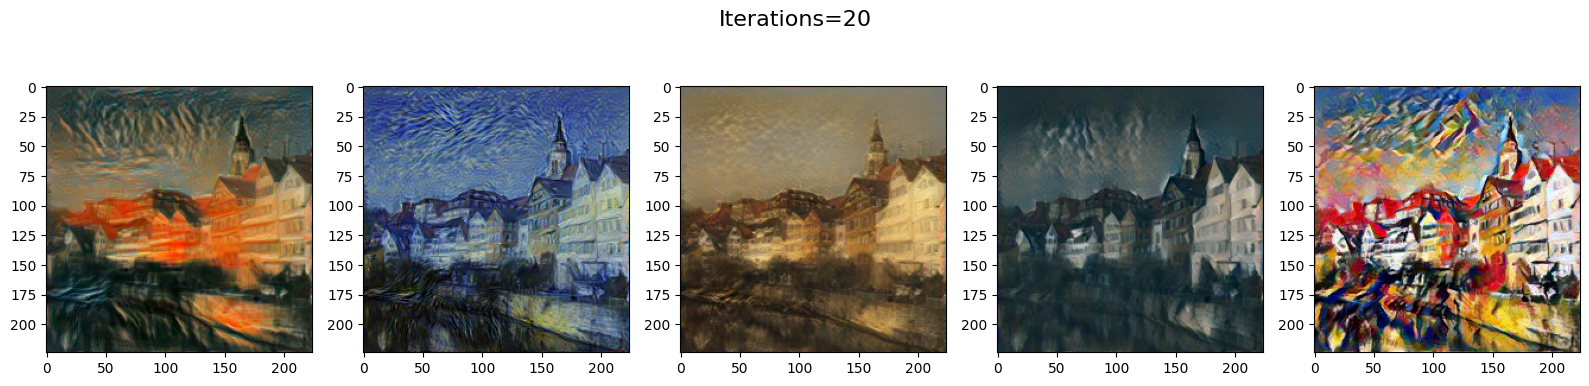

In [10]:
images = []
for style_image in style_images:
    loss, output_img = style_transfer(model=model, content_image=content_image, style_image=style_image, 
                                      alpha=1., beta=1000., iterations=20, init_output='content', normalize_gram_matrix=True)
    images.append(output_img)
    
fig = plot_images(images, "Iterations=20")

### Impact of losses in different layers

This experiments plots loss values over tranforming iterations. It was shown that CNNs feature representation of image vary thourgh layers, first layers producing lower level features and later layers producing more complex features. This experiment aligns with that observation. The loss is the highest in first layers (0, 5, 10) where style changes are being applied, while being lower in later layers as the image doesn't change too much. 

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [7]:
# Run style transfer for each image
losses = {}
for i, style_image in enumerate(style_images):
    loss, _ = style_transfer(model=model, content_image=content_image, style_image=style_image, 
                             alpha=1., beta=1000., iterations=10, init_output='content', normalize_gram_matrix=True)
    image_name = Path(style_image_paths[i]).name
    losses[image_name] = loss

Running style transfer: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.32s/it]


In [10]:
# Convert the dictionaries into DataFrames
losses_df = {
    k: pd.DataFrame(v) for k, v in losses.items()
}

In [12]:
# Example dataframe with losses per iteration
losses_df['The_Scream.jpg'].head(10)

total_content_loss  total_style_loss  content_loss_21  style_loss_0   
0        0.000000e+00          3.186681     0.000000e+00      3.045334  \
1        9.607638e-09          3.186493     9.607638e-09      3.045154   
2        5.125692e+00          0.741246     5.125692e+00      0.644632   
3        4.039642e+00          0.511657     4.039642e+00      0.451245   
4        3.289069e+00          0.409758     3.289069e+00      0.363525   
5        3.440561e+00          0.295635     3.440561e+00      0.253065   
6        3.821122e+00          0.221014     3.821122e+00      0.189973   
7        3.172941e+00          0.190994     3.172941e+00      0.163903   
8        3.003239e+00          0.169668     3.003239e+00      0.146740   
9        2.851919e+00          0.151566     2.851919e+00      0.129108   

   style_loss_5  style_loss_10  style_loss_19  style_loss_28  total_loss  
0      0.127457       0.013721       0.000167   1.386183e-06  637.336182  
1      0.127450       0.013721       0.000167   1.386135e-06  637.298645  
2      0.089522       0.007042       0.000050   3.954398e-07  153.374908  
3      0.053694       0.006643       0.000074   7.655112e-07  106.371078  
4      0.040096       0.006065       0.000072   6.990800e-07   85.240700  
5      0.036943       0.005558       0.000068   7.406539e-07   62.567558  
6      0.026595       0.004385       0.000060   6.580632e-07   48.023968  
7      0.022843       0.004171       0.000076   7.731393e-07   41.371696  
8      0.018941       0.003910       0.000076   7.936793e-07   36.936787  
9      0.018587       0.003796       0.000074   7.973461e-07   33.165047

`Loss` values have been scaled by **log** due to extremly small numbers in higher layers and larger number in others.

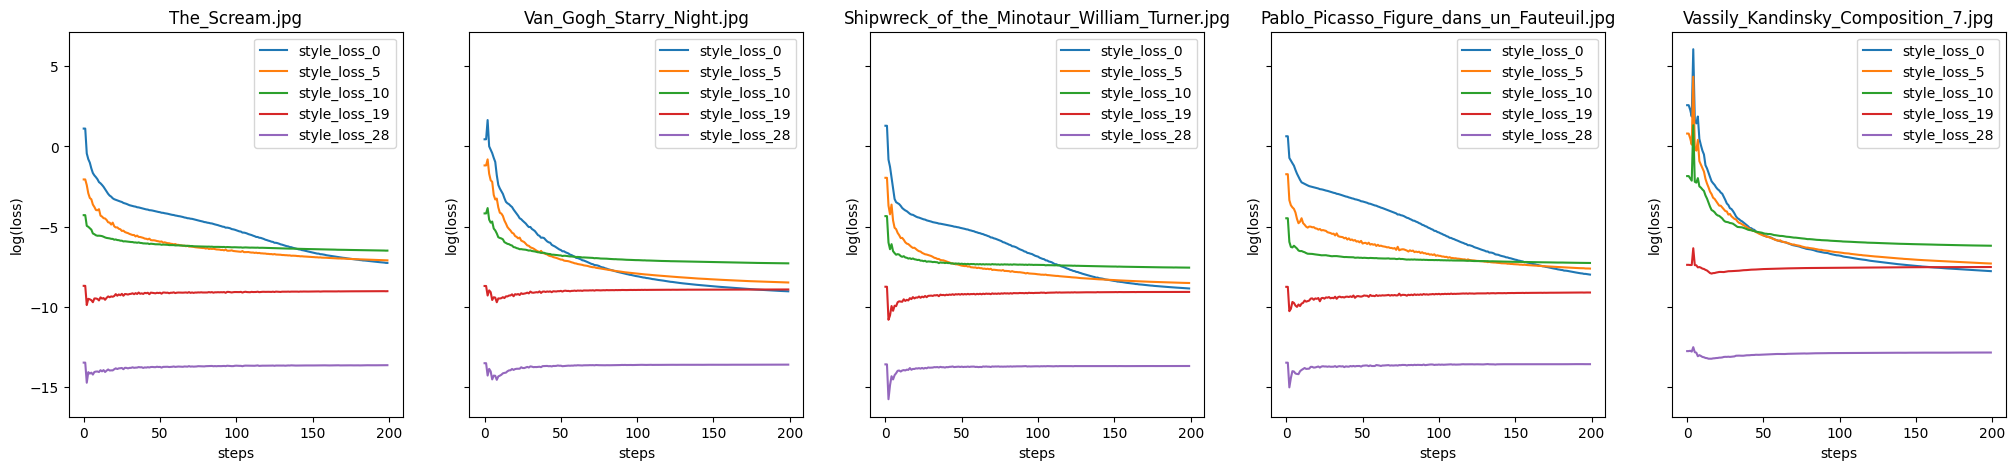

In [16]:
# Plot Style losses for each image
fig, axs = plt.subplots(1, len(losses_df), figsize=(25, 5), sharey=True)
for i, (key, loss) in enumerate(losses_df.items()):
    data = loss[['style_loss_0', 'style_loss_5', 'style_loss_10', 'style_loss_19', 'style_loss_28']].apply(np.log)
    axs[i].plot(data)
    axs[i].legend(['style_loss_0', 'style_loss_5', 'style_loss_10', 'style_loss_19', 'style_loss_28'])
    axs[i].set_title(key)
    axs[i].set_xlabel('steps')
    axs[i].set_ylabel('log(loss)')
plt.show()

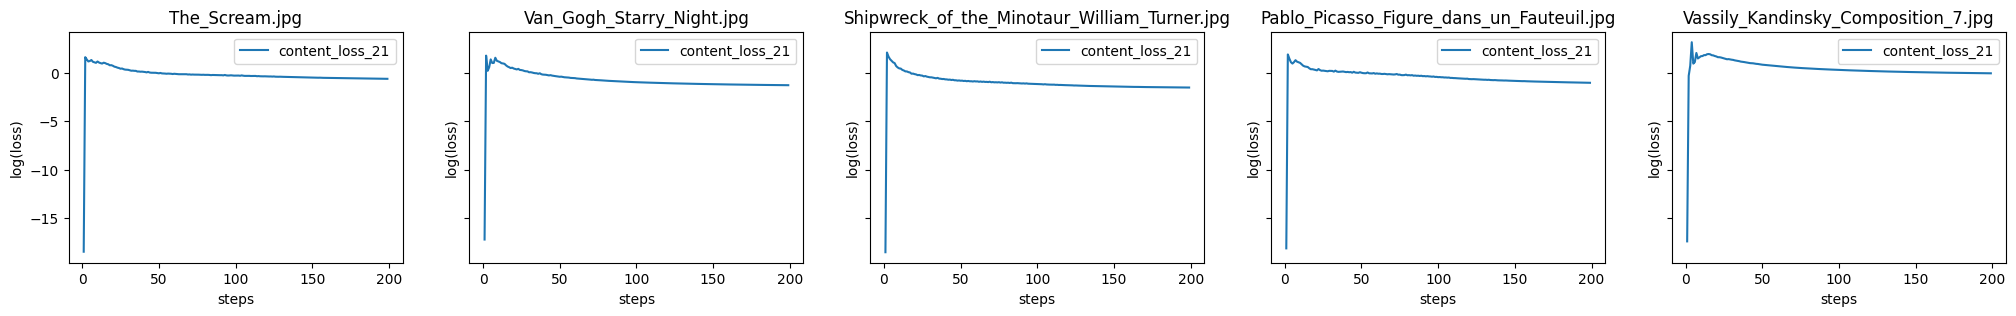

In [17]:
# Plot Content losses for each image
fig, axs = plt.subplots(1, len(losses_df), figsize=(25, 3), sharey=True)
for i, (key, loss) in enumerate(losses_df.items()):
    data = loss['content_loss_21'].apply(np.log)
    axs[i].plot(data, label='content_loss_21')
    axs[i].legend()
    axs[i].set_title(key)
    axs[i].set_xlabel('steps')
    axs[i].set_ylabel('log(loss)')
plt.show()

### Adam vs LBFGS

Tested a few experiments with various `learning_rate` and `interations` but Adam consistently got worse results. It seems like it mostly follow color scheme and less style patterns, although there might be different parameter configuration that works better. 